<a href="https://colab.research.google.com/github/b2200765028/mach-learning/blob/main/dog_cats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import torch 
import torchvision
from torch import nn
import numpy as np
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image, ImageOps
from torchvision import transforms
import glob



In [2]:
from google.colab import drive
drive.mount("/context")


Mounted at /context


/context/MyDrive


In [105]:
cat_paths =[]
dog_paths = []
path = "./temp/PetImages"
for url in glob.glob(path+"/Cat/*.jpg"):
  cat_paths.append(url)

print(len(cat_paths))

12499


In [106]:
path = "./temp/PetImages"
for url in glob.glob(path+"/Dog/*.jpg"):
  dog_paths.append(url)
print(len(dog_paths))


12499


In [107]:
img_paths = (cat_paths + dog_paths)
np.random.shuffle(img_paths)
print(img_paths)

['./temp/PetImages/Dog/9748.jpg', './temp/PetImages/Cat/9639.jpg', './temp/PetImages/Dog/7553.jpg', './temp/PetImages/Cat/8754.jpg', './temp/PetImages/Cat/4087.jpg', './temp/PetImages/Dog/1413.jpg', './temp/PetImages/Cat/10955.jpg', './temp/PetImages/Dog/2193.jpg', './temp/PetImages/Cat/4669.jpg', './temp/PetImages/Cat/1099.jpg', './temp/PetImages/Dog/1126.jpg', './temp/PetImages/Dog/8175.jpg', './temp/PetImages/Cat/950.jpg', './temp/PetImages/Dog/2673.jpg', './temp/PetImages/Dog/1966.jpg', './temp/PetImages/Dog/1019.jpg', './temp/PetImages/Dog/12149.jpg', './temp/PetImages/Cat/7034.jpg', './temp/PetImages/Dog/2441.jpg', './temp/PetImages/Cat/6932.jpg', './temp/PetImages/Cat/228.jpg', './temp/PetImages/Dog/9086.jpg', './temp/PetImages/Cat/6020.jpg', './temp/PetImages/Cat/1529.jpg', './temp/PetImages/Dog/3966.jpg', './temp/PetImages/Cat/3723.jpg', './temp/PetImages/Cat/6425.jpg', './temp/PetImages/Dog/2633.jpg', './temp/PetImages/Cat/836.jpg', './temp/PetImages/Cat/1872.jpg', './temp/Pe

In [108]:
class MyDataset(Dataset):
    def __init__(self,path,transform=None):
        
        self.path = path
        self.transform = transform
        
    def __len__(self):
        return len(self.path)
    
    def __getitem__(self,idx):
        img,label = ImageOps.grayscale(Image.open(self.path[idx])),self.path[idx].split("/")[-2]
        if self.transform is not None:
            img = self.transform(img)
        
        ##not sure if i have to label them this way , might change it
        if label =="Dog":
            label = torch.Tensor([1.])
        else:
            label = torch.Tensor([0.])
            
        sample = (img,label)

        return sample

In [109]:
class_dict = {0:"cat",1:"dog"}

In [110]:
train_transform = transforms.Compose([
    transforms.Resize((50,50)),
    transforms.ToTensor()
]   ## i will add more later
)

In [111]:
train_dataset = MyDataset(img_paths[:5000],train_transform)
test_dataset = MyDataset(img_paths[5000:7000],train_transform)

In [112]:
train_loader = DataLoader(train_dataset,batch_size=32,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=32,shuffle=True)

In [88]:
batch_idx,(img,label) = next(enumerate(train_loader))

torch.Size([32, 1, 50, 50])
Label is  cat


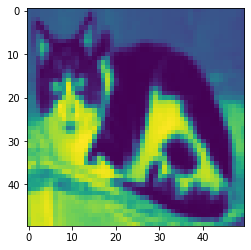

In [113]:
plt.imshow((torch.squeeze(img[5],dim=0)))
print(img.shape)
print("Label is ", class_dict[label[5].item()])  

In [114]:
len(train_loader)

157

In [115]:
class Model(nn.Module):
    def __init__(self):
              super(Model,self).__init__()
        
              self.conv1 = nn.Sequential(
              
              nn.Conv2d(1,8,kernel_size=3,stride = 1,padding =1 ),
              nn.ReLU(),
              nn.BatchNorm2d(8),
              nn.MaxPool2d(2,2),
              nn.Conv2d(8,16,3,1,1),
              nn.ReLU(),
              nn.BatchNorm2d(16),
              nn.MaxPool2d(2,2),
               nn.Dropout2d(0.2),
               nn.MaxPool2d(2,2)
            )

              self.linear =nn.Sequential(
                nn.ReLU(),
                nn.Linear(576,1000),
                nn.ReLU(),
                nn.Linear(1000,250),
                nn.ReLU(),
                nn.Linear(250,20),
                nn.ReLU(),
                nn.Linear(20,1),
                nn.Dropout(0.2) 
            )      
            
    def forward(self,x):

        x = self.conv1(x)
        x = x.view(x.shape[0],-1)
        x = self.linear(x)
        ## need it for binary
        
        return (x)

In [116]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [117]:
model = Model()
model = model.cuda()
# Define our loss function
criterion = nn.BCEWithLogitsLoss() 
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

In [118]:
probs = model(img.cuda())
(torch.sigmoid(probs)>0.5)*1.0

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')

In [ ]:
from tqdm import tqdm
epochs = 5
steps = 0
print_every =158
train_losses, test_losses = [], []

for e in range(epochs):
    running_loss = 0
    for images, labels in tqdm(train_loader,desc=f"Training model  epoch {e}/{epochs}"):
        steps += 1

        # Prevent accumulation of gradients
        optimizer.zero_grad()
        # Make predictions

        images, labels = images.cuda(), labels.cuda()

        log_ps = model(images)
     
        loss = criterion(log_ps, labels)
        
        #backprop
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0

            # Turn off gradients for validation
            with torch.no_grad():
                model.eval()
                for images, labels in test_loader:
                  
                    images, labels = images.cuda(), labels.cuda()
                    log_ps = model(images)
                    test_loss += criterion(log_ps, labels)

            
                    # Get our top predictions
                    print("before isgmoid top p",top_p)
                    top_p = ((torch.sigmoid(log_ps)>0.5)*1.0)
                    print("after sigmoid top p",top_p)
                    equals = top_p== labels.view(*top_p.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor))

            model.train()

            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(test_loader))
          

            print("Epoch: {}/{}.. ".format(e+1, epochs),
                  "Training Loss: {:.3f}.. ".format(train_losses[-1]),
                  "Test Loss: {:.3f}.. ".format(test_losses[-1]),
                  "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))

Training model  epoch 0/5:   3%|▎         | 5/157 [00:32<15:54,  6.28s/it]

In [104]:
import os
os.remove('./temp/PetImages/Cat/666.jpg')

FileNotFoundError: ignored